In [9]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
info_books = pd.read_csv('best_books_df.csv')

In [10]:
info_books.head()

,book_id,title,authors,description,average_rating,rating_dist,ratings_count,publication_date,publisher
0,2767052,"The Hunger Games (The Hunger Games, #1)",[Suzanne Collins],"Could you survive on your own, in the wild, wi...",4.33,5:3147328|4:1755372|3:677503|2:155622|1:82192|...,5610547,"('9', '14', '2008')",Scholastic Press
1,2,Harry Potter and the Order of the Phoenix (Har...,"[J.K. Rowling, Mary GrandPré]",There is a door at the end of a silent corrido...,4.49,5:1383724|4:572285|3:201775|2:35188|1:11259|to...,2050571,"('9', '1', '2004')",Scholastic Inc.
2,2657,"To Kill a Mockingbird (To Kill a Mockingbird, #1)",[Harper Lee],The unforgettable novel of a childhood in a sl...,4.27,5:2099792|4:1198789|3:521455|2:136908|1:72133|...,3840621,"('5', '23', '2006')",Harper Perennial Modern Classics
3,1885,Pride and Prejudice,"[Jane Austen, Anna Quindlen]",<i>Alternate cover edition of ISBN 97806797832...,4.25,5:1411008|4:726173|3:334977|2:102109|1:66772|t...,2433246,"('10', '10', '2000')",Modern Library
4,41865,"Twilight (Twilight, #1)",[Stephenie Meyer],<b>About three things I was absolutely positiv...,3.59,5:1575937|4:1008263|3:913735|2:496513|1:508478...,4437283,"('9', '6', '2006')","Little, Brown and Company"


In [12]:
# function to remove the 'Alternate Cover Edition ...' paragraph at the beginning 
def clean_cover_isbn(text):
  try:
    text = text.split('<br />')[2]
    return text
  except:
    return text
# function to remove html markings
from bs4 import BeautifulSoup
def clean_html(text):
  try:
    soup = BeautifulSoup(text, 'lxml')
    clean_text = soup.get_text()
    return clean_text
  except:
    return text
# function to remove punctuation
import string
def clean_punctuations(text):
    try:
      clean_text = "".join([c for c in text if c not in string.punctuation])
      return clean_text
    except:
      return text

In [13]:
info_books['description'] = info_books['description'].apply(lambda x: clean_cover_isbn(x))
info_books['description'] = info_books['description'].apply(lambda x: clean_html(x))
info_books['description'] = info_books['description'].apply(lambda x: clean_punctuations(x))

/Users/lamvo/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [14]:
def check_alphabet(text):
    try:
        return text[0][0] in 'abcdefghijklmnopqrstuvwxyz'.upper()
    except:
        return False
    
info_books['check_alphabet'] = info_books['description'].apply(lambda x: check_alphabet(x))
info_books = info_books[info_books['check_alphabet'] == True]

In [15]:
def check_alternate(text):
    return text.split(' ')[:3] == ['Alternate', 'Cover', 'Edition']

info_books['check_alternate'] = info_books['description'].apply(lambda x: check_alternate(x))
info_books = info_books[info_books['check_alternate'] == False]

In [19]:
import nltk
from nltk.tokenize import word_tokenize

In [20]:
def get_tokens(text):
    return word_tokenize(text)

In [24]:
info_books['description'] = info_books['description'].apply(lambda x: get_tokens(x))

In [26]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /Users/lamvo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
def clean_stop_words(text):
    return [word for word in text if word not in stop_words]

In [28]:
info_books['description'] = info_books['description'].apply(lambda x: clean_stop_words(x))

In [29]:
info_books.head()

,book_id,title,authors,description,average_rating,rating_dist,ratings_count,publication_date,publisher,check_alphabet,check_alternate
0,2767052,"The Hunger Games (The Hunger Games, #1)",[Suzanne Collins],"[In, ruins, place, known, North, America, lies...",4.33,5:3147328|4:1755372|3:677503|2:155622|1:82192|...,5610547,"('9', '14', '2008')",Scholastic Press,True,False
1,2,Harry Potter and the Order of the Phoenix (Har...,"[J.K. Rowling, Mary GrandPré]","[Harry, lot, mind, fifth, year, Hogwarts, Defe...",4.49,5:1383724|4:572285|3:201775|2:35188|1:11259|to...,2050571,"('9', '1', '2004')",Scholastic Inc.,True,False
2,2657,"To Kill a Mockingbird (To Kill a Mockingbird, #1)",[Harper Lee],"[Compassionate, dramatic, deeply, moving, To, ...",4.27,5:2099792|4:1198789|3:521455|2:136908|1:72133|...,3840621,"('5', '23', '2006')",Harper Perennial Modern Classics,True,False
3,1885,Pride and Prejudice,"[Jane Austen, Anna Quindlen]","[Since, immediate, success, 1813, Pride, Preju...",4.25,5:1411008|4:726173|3:334977|2:102109|1:66772|t...,2433246,"('10', '10', '2000')",Modern Library,True,False
4,41865,"Twilight (Twilight, #1)",[Stephenie Meyer],"[First, Edward, vampire]",3.59,5:1575937|4:1008263|3:913735|2:496513|1:508478...,4437283,"('9', '6', '2006')","Little, Brown and Company",True,False


In [30]:
from gensim.models.fasttext import FastText
model = FastText(min_count = 1)
model.build_vocab(sentences = list(info_books['description']))
model.train(sentences = list(info_books['description']), total_examples = len(list(info_books['description'])), epochs = 10, alpha = 0.01)

In [31]:
import numpy as np
def get_vector(text):
  vector = np.array([model.wv[word] for word in text]).mean(axis = 0)
  return vector

In [32]:
info_books['vector_description'] = info_books['description'].apply(get_vector)

In [33]:
info_books.reset_index(drop = True, inplace = True)

In [34]:
info_books.head()

,book_id,title,authors,description,average_rating,rating_dist,ratings_count,publication_date,publisher,check_alphabet,check_alternate,vector_description
0,2767052,"The Hunger Games (The Hunger Games, #1)",[Suzanne Collins],"[In, ruins, place, known, North, America, lies...",4.33,5:3147328|4:1755372|3:677503|2:155622|1:82192|...,5610547,"('9', '14', '2008')",Scholastic Press,True,False,"[-0.6969044, -1.2205406, -0.41034865, 0.274505..."
1,2,Harry Potter and the Order of the Phoenix (Har...,"[J.K. Rowling, Mary GrandPré]","[Harry, lot, mind, fifth, year, Hogwarts, Defe...",4.49,5:1383724|4:572285|3:201775|2:35188|1:11259|to...,2050571,"('9', '1', '2004')",Scholastic Inc.,True,False,"[-0.9135939, -0.7789845, -0.04543928, 0.186205..."
2,2657,"To Kill a Mockingbird (To Kill a Mockingbird, #1)",[Harper Lee],"[Compassionate, dramatic, deeply, moving, To, ...",4.27,5:2099792|4:1198789|3:521455|2:136908|1:72133|...,3840621,"('5', '23', '2006')",Harper Perennial Modern Classics,True,False,"[-0.9647614, -0.4705716, -0.6905037, 0.7129199..."
3,1885,Pride and Prejudice,"[Jane Austen, Anna Quindlen]","[Since, immediate, success, 1813, Pride, Preju...",4.25,5:1411008|4:726173|3:334977|2:102109|1:66772|t...,2433246,"('10', '10', '2000')",Modern Library,True,False,"[-0.8046582, -0.34081048, -0.42817596, 0.46078..."
4,41865,"Twilight (Twilight, #1)",[Stephenie Meyer],"[First, Edward, vampire]",3.59,5:1575937|4:1008263|3:913735|2:496513|1:508478...,4437283,"('9', '6', '2006')","Little, Brown and Company",True,False,"[-1.3840384, -1.5197188, -0.5777206, -0.691673..."


In [35]:
X = list(info_books['vector_description'])
X = np.array(X)
X.shape

(41448, 100)

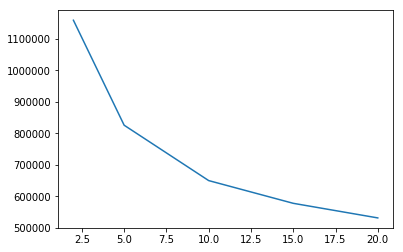

In [36]:
from sklearn.cluster import KMeans
n_clusters = [2, 5, 10, 15, 20]
inertia = []
for n in n_clusters:
  book_kmeans = KMeans(n_clusters = n)
  book_kmeans.fit(X)
  inertia.append(book_kmeans.inertia_)

plt.plot(n_clusters, inertia)

In [37]:
book_kmeans = KMeans(n_clusters = 10, random_state = 10).fit(X)
book_kmeans.labels_

array([4, 4, 9, ..., 4, 4, 0], dtype=int32)

In [38]:
len(book_kmeans.labels_)

41448

In [39]:
info_books['cluster'] = pd.Series(book_kmeans.labels_)

In [15]:
info_books.to_csv('best_books_clustered.csv', index = False)

In [40]:
info_books[info_books['cluster'] == 7]

,book_id,title,authors,description,average_rating,rating_dist,ratings_count,publication_date,publisher,check_alphabet,check_alternate,vector_description,cluster
1191,10625,Dolores Claiborne,"[Stephen King, Dominique Dill]","[Aujourdhui, la, vieille, dame, indigne, est, ...",3.85,5:35052|4:39661|3:30449|2:8152|1:1814|total:11...,70871,"('11', '6', '1996')",Pocket,True,False,"[0.59224963, -0.9165474, -2.87444, -1.652479, ...",7
1247,10611,The Eyes of the Dragon,[Stephen King],"[Il, était, une, fois, un, roi, qui, vivait, d...",3.93,5:31738|4:33656|3:22646|2:5659|1:1448|total:95147,82337,"(None, None, None)",Time Warner Paperbacks,True,False,"[0.47233984, -1.1836138, -2.453941, -2.3202434...",7
1468,141828,L'Écume des jours,[Boris Vian],"[Chick, Alise, Chloé, et, Colin, passent, leur...",4.00,5:9649|4:7610|3:4226|2:1580|1:779|total:23844,16941,"('2', '26', '1997')",Le Livre de Poche,True,False,"[0.656277, -1.2025247, -2.3891108, -1.9872937,...",7
1517,43600950,The Mountain's Morning Song,[William Graney],"[La, Société, de, la, Frontière, Ouverte, must...",4.44,5:130|4:150|3:3|2:1|1:0|total:284,284,"('1', '16', '2019')",NaN,True,False,"[0.39666066, -1.1020937, -1.8970932, -2.037625...",7
1834,11570,Dreamcatcher,"[Stephen King, William Olivier Desmond, Maria ...","[Stephen, King, au, sommet, de, son, talent, c...",3.62,5:36280|4:42074|3:41664|2:15535|1:5771|total:1...,132775,"('3', '1', '2002')",Albin Michel,True,False,"[0.6372574, -1.5271367, -1.6527268, -2.7938213...",7
2655,47780,Hunting and Gathering,"[Anna Gavalda, Alison Anderson]","[Ce, livre, ne, raconte, rien, dautre, quune, ...",4.11,5:6319|4:5565|3:2627|2:716|1:212|total:15439,7939,"(None, None, None)",NaN,True,False,"[-0.35484943, -0.7833707, -1.412408, -1.298118...",7
2935,61672,Bonjour tristesse,[Françoise Sagan],"[La, villa, est, magnifique, lété, brûlant, la...",3.63,5:4839|4:8440|3:7421|2:2199|1:552|total:23451,16386,"('9', '16', '2002')",Pocket,True,False,"[0.61842644, -1.0593405, -2.1915987, -1.776056...",7
3355,37800210,Gris Ange 2014,[Lucio Agustine Rosenkreutz Crăciunescu],"[Basé, sur, la, biographie, de, Lucio, Agustin...",5.00,5:9|4:0|3:0|2:0|1:0|total:9,9,"('1', '8', '2014')",Ocean Digital Edition,True,False,"[0.4645515, -1.094023, -1.910568, -2.5482037, ...",7
3365,37757861,Coeur pourri de laine (DF),[Lucio Agustine Rosenkreutz Crăciunescu],"[Livre, écrit, par, Lucio, Rosenkreutz, le, 14...",5.00,5:9|4:0|3:0|2:0|1:0|total:9,9,"('11', '19', '2017')",Dauphin Groupe Ltd.,True,False,"[0.065850325, -0.9253195, -2.0102286, -1.43552...",7
3490,2133827,La Mécanique du cœur,[Mathias Malzieu],"[Le, jour, de, la, naissance, de, Jack, en, 18...",3.60,5:4154|4:5380|3:4956|2:1954|1:701|total:17145,6328,"('10', '22', '2007')",Flammarion,True,False,"[0.45815992, -1.5646428, -2.0033176, -2.691588...",7


In [20]:
def get_cosine_similarity(one, two):
    return np.dot(one, two)/(np.linalg.norm(one) * np.linalg.norm(two))

In [21]:
a = np.array([1, 2, 3])
b = np.array([0, 1, 1])
get_cosine_similarity(a, b)

0.944911182523068

In [161]:
import nltk
from nltk.tokenize import word_tokenize

In [41]:
from goodreads import client
goodreads_key = 't6mIkabukH29jAey0381yA'
goodreads_secret = '6IWvvO5CNFIAqUragee2Bb5HkEOvxIYqSXeXdFSHvM'
good_client = client.GoodreadsClient(goodreads_key, goodreads_secret)

In [42]:
test_book = good_client.book('77156')

In [43]:
test_book_description = test_book.description

In [44]:
test_book_vector = clean_cover_isbn(test_book_description)
test_book_vector = clean_html(test_book_vector)
test_book_vector = clean_punctuations(test_book_vector)
test_book_vector = get_tokens(test_book_vector)
test_book_vector = get_vector(test_book_vector)

In [45]:
test_book_vector = np.reshape(test_book_vector, (1, 100))

In [46]:
cluster_number = book_kmeans.predict(test_book_vector).item()

In [47]:
predicted_cluster = info_books[info_books['cluster'] == cluster_number]

In [48]:
predicted_cluster

,book_id,title,authors,description,average_rating,rating_dist,ratings_count,publication_date,publisher,check_alphabet,check_alternate,vector_description,cluster
0,2767052,"The Hunger Games (The Hunger Games, #1)",[Suzanne Collins],"[In, ruins, place, known, North, America, lies...",4.33,5:3147328|4:1755372|3:677503|2:155622|1:82192|...,5610547,"('9', '14', '2008')",Scholastic Press,True,False,"[-0.6969044, -1.2205406, -0.41034865, 0.274505...",4
1,2,Harry Potter and the Order of the Phoenix (Har...,"[J.K. Rowling, Mary GrandPré]","[Harry, lot, mind, fifth, year, Hogwarts, Defe...",4.49,5:1383724|4:572285|3:201775|2:35188|1:11259|to...,2050571,"('9', '1', '2004')",Scholastic Inc.,True,False,"[-0.9135939, -0.7789845, -0.04543928, 0.186205...",4
5,19063,The Book Thief,[Markus Zusak],"[By, brothers, graveside, Liesels, life, chang...",4.37,5:919718|4:466625|3:166324|2:43586|1:22884|tot...,1447666,"('3', '14', '2006')",Alfred A. Knopf,True,False,"[-0.77085465, -0.79860824, -0.2639821, 0.40732...",4
7,30,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,[J.R.R. Tolkien],"[In, The, Hobbit, Bilbo, Baggins, whisked, awa...",4.59,5:72925|4:21740|3:6277|2:1412|1:891|total:103245,98994,"('9', '25', '2012')",Ballantine Books,True,False,"[-0.61019015, -1.1201456, -0.1765747, 0.455924...",4
16,10210,Jane Eyre,"[Charlotte Brontë, Michael Mason, João Gaspar...","[Orphaned, child, Jane, felt, outcast, whole, ...",4.12,5:668147|4:456004|3:236920|2:71228|1:39453|tot...,1359503,"('2', '4', '2003')",Penguin,True,False,"[-1.0316291, -1.0589359, -0.119859636, -0.2196...",4
17,13335037,"Divergent (Divergent, #1)",[Veronica Roth],"[During, highly, competitive, initiation, foll...",4.21,5:1300194|4:806021|3:388739|2:108271|1:48930|t...,2315399,"('2', '28', '2012')",Katherine Tegen Books,True,False,"[-0.45677572, -1.108792, -0.7211877, 0.4490724...",4
19,7624,Lord of the Flies,[William Golding],"[At, dawn, next, world, war, plane, crashes, u...",3.67,5:547876|4:689366|3:506670|2:189208|1:111232|t...,1951486,"('10', '1', '1999')",Penguin Books,True,False,"[-0.6966811, -0.92746526, -0.39869678, -0.0949...",4
21,7144,Crime and Punishment,"[Fyodor Dostoyevsky, David McDuff]","[Raskolnikov, destitute, desperate, former, st...",4.21,5:272410|4:166578|3:76128|2:24060|1:11701|tota...,463757,"('12', '31', '2002')",Penguin,True,False,"[-0.6431839, -0.96107864, -0.73659754, 0.28577...",4
22,375802,"Ender's Game (Ender's Saga, #1)",[Orson Scott Card],"[But, Ender, result, experiment, The, war, Bug...",4.30,5:547355|4:309790|3:120357|2:32093|1:17842|tot...,952522,"('7', None, '1994')",TOR,True,False,"[-0.65986025, -1.0862275, -0.54430574, 0.41702...",4
27,24178,Charlotte's Web,"[E.B. White, Garth Williams, Rosemary Wells]","[Some, Pig, Humble, Radiant, These, words, Cha...",4.16,5:592390|4:400069|3:217309|2:47724|1:23217|tot...,1255235,"('10', '1', '2001')",HarperCollinsPublishers,True,False,"[-0.73697394, -0.77650756, 0.16782056, -0.2044...",4


In [ ]:
# 20 books that are most similar to the query book
# choose 5 books 